# Advanced ANNs: Custom Loss Functions

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
import copy
import metpy
import metpy.calc

In [2]:
# we will set the seed this time to ensure fairness
keras.utils.set_random_seed(1)

In [3]:
al_asos = pd.read_csv("../Week_6/al_asos_jul_23_v2.csv")
us_asos = pd.read_csv("../../../../combined_asos_2023.csv")

In [4]:
def nws_heat_index(T, RH):
    '''
    T in fahrenheit, RH in %
    https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml
    '''
    # new addition!
    if T <65:
        return T
    initial_hi =  0.5 * (T + 61.0 + ((T-68.0)*1.2) + (RH*0.094))
    if initial_hi < 80:
        return initial_hi

    adjustment_factor = 0
    if T>=80 and T<=112 and RH <13:
        adjustment_factor =  ((13-RH)/4)*np.sqrt((17-np.abs(T-95.))/17)
    
    if T>=80 and T<=87 and RH > 85:
         adjustment_factor = ((RH-85)/10) * ((87-T)/5)

    return (-42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - 
           .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH) + adjustment_factor

nws_heat_index_vectorized = np.vectorize(nws_heat_index)

In [5]:
al_asos['heat_index'] = nws_heat_index_vectorized(al_asos["tmpf"], al_asos['relh'])

<Axes: >

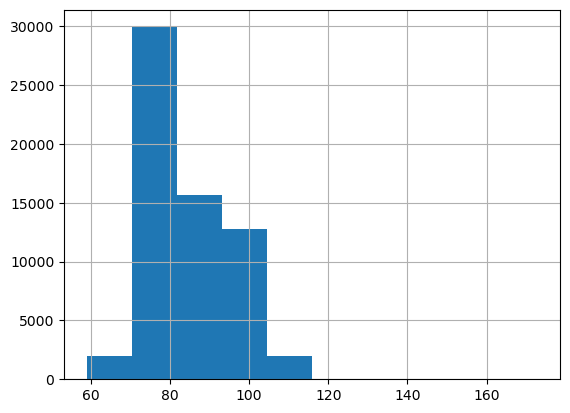

In [6]:
al_asos['heat_index'].hist()

In [7]:
us_asos['relh_raw'] = metpy.calc.relative_humidity_from_dewpoint(us_asos['tmpf'].values*metpy.units.units("degF"), 
                                                             us_asos['dwpf'].values*metpy.units.units("degF")).magnitude*100

In [8]:
us_asos['relh'] = us_asos['relh_raw'].clip(0,100)

In [9]:
us_asos['heat_index'] = nws_heat_index_vectorized(us_asos["tmpf"], us_asos['relh'])

<Axes: >

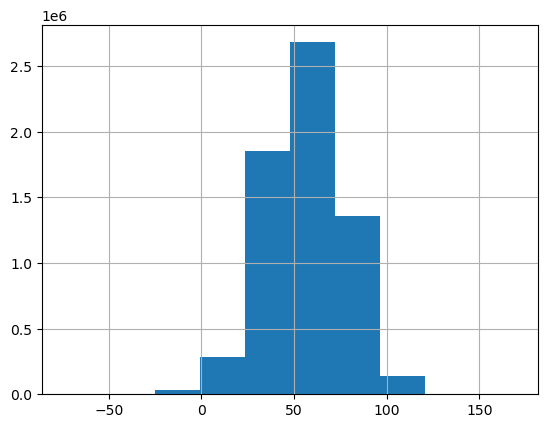

In [10]:
us_asos['heat_index'].hist()

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
al_asos_nona = al_asos.dropna(subset=['tmpf', 'relh', 'heat_index'])

In [13]:
# Prepare our data first
training_data_AL, test_validation_AL = train_test_split(al_asos_nona, test_size=0.25)
testing_data_AL, validation_data_AL = train_test_split(test_validation_AL, test_size=0.5)

In [14]:
len(training_data_AL), len(testing_data_AL), len(validation_data_AL)

(46868, 7811, 7812)

<Axes: >

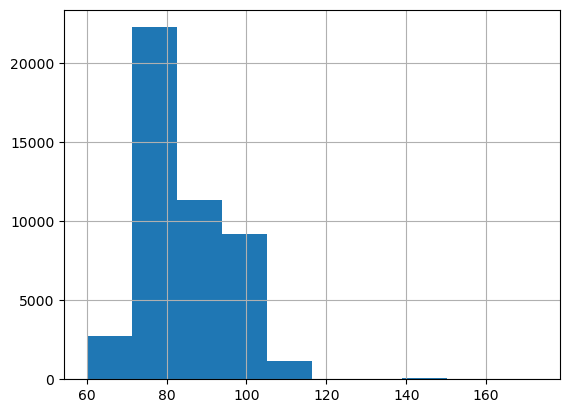

In [15]:
training_data_AL['heat_index'].hist()

In [16]:
tf.keras.backend.clear_session()
keras.utils.set_random_seed(13)
input1 = keras.layers.Input(shape=(2, ))
input_norm = keras.layers.Normalization(axis=1)(input1)


dense1 = keras.layers.Dense(128,  activation=None)(input_norm)
lerelu_layer = keras.layers.LeakyReLU(alpha=0.3)(dense1) 

output = keras.layers.Dense(1, activation=keras.activations.relu)(lerelu_layer)
model_AL = keras.models.Model(inputs=[input1], outputs=[output])
model_AL.compile(optimizer=keras.optimizers.legacy.Adam(), loss='mean_squared_error')
model_AL.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 normalization (Normalizati  (None, 2)                 5         
 on)                                                             
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 518 (2.03 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 5 (24.00 Byte)
______________________________

2024-03-27 22:17:41.234205: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-27 22:17:41.234227: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-03-27 22:17:41.234237: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-03-27 22:17:41.234269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-27 22:17:41.234286: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
model_AL.fit(training_data_AL[['tmpf', 'relh']].values, 
           training_data_AL['heat_index'].values, epochs=3, batch_size=128, 
           validation_data= (validation_data_AL[['tmpf', 'relh']].values, validation_data_AL['heat_index'].values))

Epoch 1/3
 12/367 [..............................] - ETA: 1s - loss: 3891.9888  

2024-03-27 22:17:43.929269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


367/367 [==============================] - 2s 5ms/step - loss: 214.9338 - val_loss: 16.2455
Epoch 2/3
367/367 [==============================] - 2s 4ms/step - loss: 15.3223 - val_loss: 16.0089
Epoch 3/3
367/367 [==============================] - 2s 4ms/step - loss: 14.9799 - val_loss: 15.6328


In [18]:
predicted_hi_AL = model_AL.predict(testing_data_AL[['tmpf', 'relh']].values)

245/245 [==============================] - 0s 2ms/step


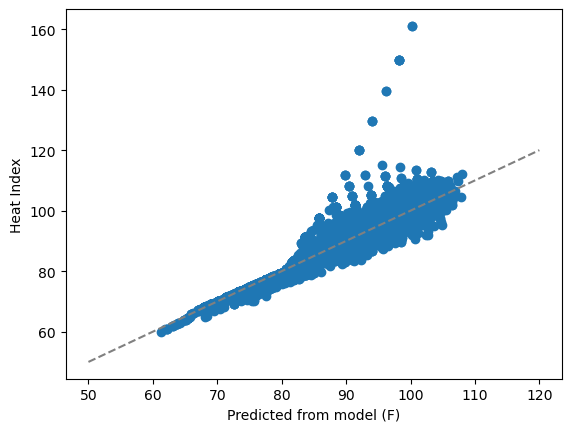

In [19]:
plt.scatter(predicted_hi_AL, testing_data_AL['heat_index'])
plt.xlabel("Predicted from model (F)")
plt.ylabel("Heat Index")
#plt.xlim(50, 120)
#plt.ylim(50, 120)
plt.plot([50, 120], [50, 120], color='grey', ls='--')

In [20]:
def loss_function_basic_mse(y_true, y_pred):
    mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
    return mse

In [22]:
tf.keras.backend.clear_session()
keras.utils.set_random_seed(13)
input1 = keras.layers.Input(shape=(2, ))
input_norm = keras.layers.Normalization(axis=-1)(input1)


dense1 = keras.layers.Dense(128, activation=None)(input_norm)
lerelu_layer = keras.layers.LeakyReLU(alpha=0.3)(dense1) 

output = keras.layers.Dense(1, activation=keras.activations.relu)(lerelu_layer)
model_AL = keras.models.Model(inputs=[input1], outputs=[output])
model_AL.compile(optimizer=keras.optimizers.legacy.Adam(), loss=loss_function_basic_mse)
model_AL.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 normalization (Normalizati  (None, 2)                 5         
 on)                                                             
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 518 (2.03 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 5 (24.00 Byte)
______________________________

In [23]:
model_AL.fit(training_data_AL[['tmpf', 'relh']].values, 
           training_data_AL['heat_index'].values, epochs=3, batch_size=128, 
           validation_data= (validation_data_AL[['tmpf', 'relh']].values, validation_data_AL['heat_index'].values))

Epoch 1/3
367/367 [==============================] - 2s 4ms/step - loss: 214.9338 - val_loss: 16.2455
Epoch 2/3
367/367 [==============================] - 1s 4ms/step - loss: 15.3223 - val_loss: 16.0089
Epoch 3/3
367/367 [==============================] - 1s 4ms/step - loss: 14.9799 - val_loss: 15.6328


245/245 [==============================] - 0s 1ms/step


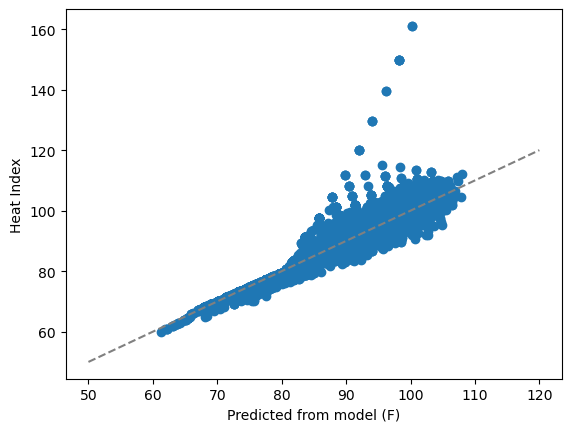

In [24]:
predicted_hi_AL = model_AL.predict(testing_data_AL[['tmpf', 'relh']].values)
plt.scatter(predicted_hi_AL, testing_data_AL['heat_index'])
plt.xlabel("Predicted from model (F)")
plt.ylabel("Heat Index")
#plt.xlim(50, 120)
#plt.ylim(50, 120)
plt.plot([50, 120], [50, 120], color='grey', ls='--')

In [83]:
def loss_function_physics_mse(truth_data, y_pred):
    y_true = truth_data[:, 0]
    temp = truth_data[:,1]
    mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
    return tf.where(y_pred<temp, tf.add(mse,999.0), mse) 

def mse_new_data(truth_data, y_pred):
    y_true = truth_data[:, 0]
    mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
    return mse


In [84]:
tf.keras.backend.clear_session()
keras.utils.set_random_seed(13)
input1 = keras.layers.Input(shape=(2, ))
input_norm = keras.layers.Normalization(axis=-1)(input1)


dense1 = keras.layers.Dense(128, activation=None)(input_norm)
lerelu_layer = keras.layers.LeakyReLU(alpha=0.3)(dense1) 

output = keras.layers.Dense(1, activation=keras.activations.relu)(lerelu_layer)
model_AL = keras.models.Model(inputs=[input1], outputs=[output])

model_AL.compile(optimizer=keras.optimizers.legacy.Adam(), 
                 loss=loss_function_physics_mse,
                 metrics=[mse_new_data])
model_AL.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 normalization (Normalizati  (None, 2)                 5         
 on)                                                             
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 518 (2.03 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 5 (24.00 Byte)
______________________________

In [85]:
y_truth = training_data_AL[['heat_index']].values
model_AL.fit(training_data_AL[['tmpf', 'relh']].values, 
             np.append(y_truth, training_data_AL[['tmpf']].values, axis =1)
           , epochs=10, batch_size=256, )

Epoch 1/10
184/184 [==============================] - 1s 5ms/step - loss: 851.5396 - mse_new_data: 456.0049
Epoch 2/10
184/184 [==============================] - 1s 5ms/step - loss: 413.6472 - mse_new_data: 122.9251
Epoch 3/10
184/184 [==============================] - 1s 4ms/step - loss: 412.0312 - mse_new_data: 122.7190
Epoch 4/10
184/184 [==============================] - 1s 5ms/step - loss: 413.0101 - mse_new_data: 122.8813
Epoch 5/10
184/184 [==============================] - 1s 5ms/step - loss: 411.9872 - mse_new_data: 122.6088
Epoch 6/10
184/184 [==============================] - 1s 4ms/step - loss: 412.4789 - mse_new_data: 122.7888
Epoch 7/10
184/184 [==============================] - 1s 4ms/step - loss: 411.8611 - mse_new_data: 122.8249
Epoch 8/10
184/184 [==============================] - 1s 5ms/step - loss: 411.8830 - mse_new_data: 122.9622
Epoch 9/10
184/184 [==============================] - 1s 5ms/step - loss: 411.6719 - mse_new_data: 122.5802
Epoch 10/10
184/184 [=======

245/245 [==============================] - 0s 2ms/step


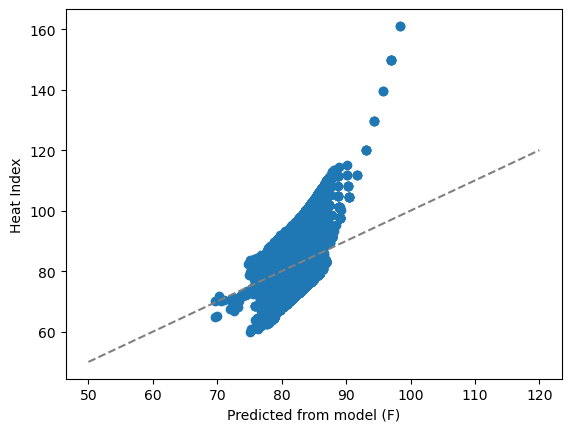

In [82]:
predicted_hi_AL = model_AL.predict(testing_data_AL[['tmpf', 'relh']].values)
plt.scatter(predicted_hi_AL, testing_data_AL['heat_index'])
plt.xlabel("Predicted from model (F)")
plt.ylabel("Heat Index")
#plt.xlim(50, 120)
#plt.ylim(50, 120)
plt.plot([50, 120], [50, 120], color='grey', ls='--')

In [88]:
# Prepare our data first
use_data_AL, _ = train_test_split(al_asos_nona, test_size=0.98)
training_data_AL, test_validation_AL = train_test_split(use_data_AL, test_size=0.25)
testing_data_AL, validation_data_AL = train_test_split(test_validation_AL, test_size=0.5)

In [89]:
len(training_data_AL)

936

In [90]:
tf.keras.backend.clear_session()
keras.utils.set_random_seed(13)
input1 = keras.layers.Input(shape=(2, ))
input_norm = keras.layers.Normalization(axis=-1)(input1)


dense1 = keras.layers.Dense(256, activation=None)(input_norm)
lerelu_layer = keras.layers.LeakyReLU(alpha=0.3)(dense1) 

output = keras.layers.Dense(1, activation=keras.activations.relu)(lerelu_layer)
model_AL = keras.models.Model(inputs=[input1], outputs=[output])

model_AL.compile(optimizer=keras.optimizers.legacy.Adam(), 
                 loss=loss_function_physics_mse,
                 metrics=[mse_new_data])
model_AL.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 normalization (Normalizati  (None, 2)                 5         
 on)                                                             
                                                                 
 dense (Dense)               (None, 256)               768       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1030 (4.03 KB)
Trainable params: 1025 (4.00 KB)
Non-trainable params: 5 (24.00 Byte)
____________________________

In [92]:
y_truth = training_data_AL[['heat_index']].values
model_AL.fit(training_data_AL[['tmpf', 'relh']].values, 
             np.append(y_truth, training_data_AL[['tmpf']].values, axis =1)
           , epochs=30, batch_size=128, )

Epoch 1/30
8/8 [==============================] - 0s 21ms/step - loss: 282.0067 - mse_new_data: 164.8307
Epoch 2/30
8/8 [==============================] - 0s 7ms/step - loss: 362.2727 - mse_new_data: 122.8567
Epoch 3/30
8/8 [==============================] - 0s 5ms/step - loss: 467.4295 - mse_new_data: 123.0698
Epoch 4/30
8/8 [==============================] - 0s 5ms/step - loss: 486.3562 - mse_new_data: 118.9658
Epoch 5/30
8/8 [==============================] - 0s 5ms/step - loss: 447.4085 - mse_new_data: 118.1538
Epoch 6/30
8/8 [==============================] - 0s 7ms/step - loss: 404.7686 - mse_new_data: 116.1250
Epoch 7/30
8/8 [==============================] - 0s 6ms/step - loss: 390.1295 - mse_new_data: 115.8129
Epoch 8/30
8/8 [==============================] - 0s 5ms/step - loss: 399.8706 - mse_new_data: 113.8825
Epoch 9/30
8/8 [==============================] - 0s 5ms/step - loss: 407.4521 - mse_new_data: 111.6307
Epoch 10/30
8/8 [==============================] - 0s 5ms/step 